In [2]:
import pandas as pd

In [50]:
results = pd.read_csv('../ewf_results.csv')

results['Metric'] = results['Metric'].str.replace('-', 'uniform')

relevant_results = results[['Metric', 'Lower Cutoff Value', 'Upper Cutoff Value', 'Task 1 - 4', 'Task 2 - 4', 'Task 3 - 4', 'Task 4 - 4']]

# Using melt to perform the pivot_longer equivalent
long_format = relevant_results.melt(
    id_vars=['Metric', 'Lower Cutoff Value', 'Upper Cutoff Value'], 
    value_vars=['Task 1 - 4', 'Task 2 - 4', 'Task 3 - 4', 'Task 4 - 4'],
    var_name='Task',
    value_name='Value'
)

# Cleaning up the 'Task' column to extract only the task number
long_format['Task'] = long_format['Task'].str.extract(r'(\d)')

In [51]:
cutoff_summary = long_format[long_format['Metric'] != 'uniform'].groupby(['Lower Cutoff Value', 'Upper Cutoff Value']).mean('Value').reset_index()
            
display(cutoff_summary)

cutoff_summary.to_csv('ewf_cutoff_summary.csv', index=False)

,Lower Cutoff Value,Upper Cutoff Value,Value
0,20,20,0.060876
1,20,35,0.061092
2,20,50,0.060943
3,35,20,0.061713
4,35,35,0.062306
5,35,50,0.062000


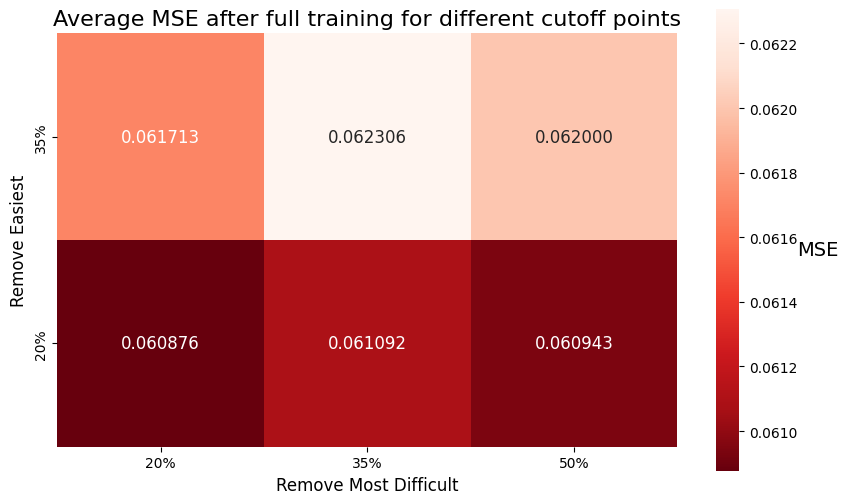

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


# Assuming cutoff_summary is your DataFrame and is already available
heatmap = cutoff_summary.pivot(index='Lower Cutoff Value', columns='Upper Cutoff Value', values='Value')

heatmap = heatmap.iloc[::-1]

# Plotting the heatmap with square cells and labeled color bar
plt.figure(figsize=(10, 6))  # Optional, for better size
ax = sns.heatmap(
    heatmap,
    annot=True,
    cmap='Reds_r',  # Use the custom warm colormap
    fmt='.6f',
    square=True,
    annot_kws={'size': 12},  # Increase font size inside cells (adjust the value as needed)
    cbar_kws={'label': 'MSE'}  # Label for the color bar
)

# Adjusting the color bar label position with added margin and increased font size
colorbar = ax.collections[0].colorbar
colorbar.set_label('MSE', rotation=0, labelpad=15, fontsize=14)

# Set axis labels
ax.set_xlabel('Remove Most Difficult', fontsize=12)
ax.set_ylabel('Remove Easiest', fontsize=12)

# Increase title size
plt.title('Average MSE after full training for different cutoff points', fontsize=16)  # Increased title size

# Adding percentage symbols to the xticks and yticks
ax.set_xticklabels([f'{x}%' for x in heatmap.columns])
ax.set_yticklabels([f'{y}%' for y in heatmap.index])

# Show the plot
plt.show()


In [91]:
cutoff_summary

,Lower Cutoff Value,Upper Cutoff Value,Value
0,20,20,0.060876
1,20,35,0.061092
2,20,50,0.060943
3,35,20,0.061713
4,35,35,0.062306
5,35,50,0.062000


In [102]:
ewf_best_cutoff_results = long_format[(long_format['Lower Cutoff Value'] == 20) & (long_format['Upper Cutoff Value'] == 20)]

best_cutoff_summary = ewf_best_cutoff_results.groupby(['Metric'])['Value'].agg(['mean']).reset_index()

display(best_cutoff_summary)

best_cutoff_summary.to_csv('ewf_best_cutoff_results.csv', index=False)

,Metric,mean
0,learning_speed,0.060317
1,mc_variance,0.061094
2,uniform,0.060924
3,vog,0.061218


In [122]:
import numpy as np
from scipy.stats import t

best_cutoff_per_task_summary = ewf_best_cutoff_results.groupby(['Metric', 'Task']).agg(['mean', 'std'])[['Value']].reset_index()

# for task in range(1, 5):
#     task_results = best_cutoff_per_task_summary[best_cutoff_per_task_summary['Task'] == str(task)]

#     for metric1 in ['learning_speed']:
#         for metric2 in ['uniform']:
#             if metric1 == metric2:
#                 continue

#             t_value = (task_results[task_results['Metric'] == metric1]['Value']['mean'].values - task_results[task_results['Metric'] == metric2]['Value']['mean'].values) / np.sqrt(task_results[task_results['Metric'] == metric1]['Value']['std'].values ** 2 / 5 + task_results[task_results['Metric'] == metric2]['Value']['std'].values ** 2 / 5)
#             df = 8

#             p_value_two_tailed = 2 * (1 - t.cdf(abs(t_value), df))

#             print(f'Task {task} - {metric1} vs {metric2}: {p_value_two_tailed}')

display(best_cutoff_per_task_summary)

best_cutoff_per_task_summary.to_csv('ewf_best_cutoff_results_per_task.csv', index=False)

Metric Task     Value          
                             mean       std
0   learning_speed    1  0.086213  0.006233
1   learning_speed    2  0.040634  0.002049
2   learning_speed    3  0.049224  0.002287
3   learning_speed    4  0.065198  0.002092
4      mc_variance    1  0.087089  0.010650
5      mc_variance    2  0.041068  0.001573
6      mc_variance    3  0.049231  0.001646
7      mc_variance    4  0.066987  0.001994
8          uniform    1  0.087133  0.008297
9          uniform    2  0.041130  0.002044
10         uniform    3  0.048815  0.003366
11         uniform    4  0.066620  0.003216
12             vog    1  0.088868  0.006142
13             vog    2  0.040786  0.001402
14             vog    3  0.048391  0.001979
15             vog    4  0.066825  0.003543

In [101]:
import scipy.stats as stats

# Sample data (assuming 5 observations for each metric based on the mean and std)
learning_speed = [0.060317 + i * 0.018116 for i in range(-2, 3)]
mc_variance = [0.061094 + i * 0.018850 for i in range(-2, 3)]
uniform = [0.060924 + i * 0.018733 for i in range(-2, 3)]
vog = [0.061218 + i * 0.019351 for i in range(-2, 3)]

# Combine data
data = [learning_speed, mc_variance, uniform, vog]

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(*data)

print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")


F-statistic: 0.0009, p-value: 1.0000


In [123]:
from scipy.stats import t
import numpy as np

# Sample data for Learning Speed and Uniform metrics for each task
# Mean and std for Learning Speed and Uniform for each task
learning_speed_means = [0.086213, 0.040634, 0.049224, 0.065198]
uniform_means = [0.087133, 0.041130, 0.048815, 0.066620]

learning_speed_stds = [0.006233, 0.002049, 0.002287, 0.002092]
uniform_stds = [0.008297, 0.002044, 0.003366, 0.003216]

# Number of samples (5)
n = 5

# Calculate t-statistics and p-values for each task
for i in range(4):
    mean1, mean2 = learning_speed_means[i], uniform_means[i]
    std1, std2 = learning_speed_stds[i], uniform_stds[i]

    # Calculate the t-statistic
    t_stat = (mean1 - mean2) / np.sqrt((std1**2 / n) + (std2**2 / n))
    
    # Degrees of freedom
    df = 2 * n - 2
    
    # Calculate the p-value for two-tailed test
    p_value = 2 * (1 - t.cdf(abs(t_stat), df))
    
    # Output the results
    print(f"Task {i+1}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    
    if p_value < 0.05:
        print("Result: Statistically significant difference between Learning Speed and Uniform\n")
    else:
        print("Result: No statistically significant difference between Learning Speed and Uniform\n")


Task 1: t-statistic = -0.1982, p-value = 0.8478
Result: No statistically significant difference between Learning Speed and Uniform

Task 2: t-statistic = -0.3832, p-value = 0.7115
Result: No statistically significant difference between Learning Speed and Uniform

Task 3: t-statistic = 0.2247, p-value = 0.8278
Result: No statistically significant difference between Learning Speed and Uniform

Task 4: t-statistic = -0.8288, p-value = 0.4313
Result: No statistically significant difference between Learning Speed and Uniform

